In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../../plotting.mplstyle')

In [2]:
import cymetric as cym
from cymetric import filters
from cymetric import graphs
from cymetric import timeseries
from cymetric import tools
import graphviz
import sqlite3

In [3]:
import importlib.util

# Specify the path relative to the current notebook's directory
dep_spec = importlib.util.spec_from_file_location('deployment', '../../scripts/deployment.py')
dep = importlib.util.module_from_spec(dep_spec)
dep_spec.loader.exec_module(dep)

tran_spec = importlib.util.spec_from_file_location('fuel_transactions', '../../scripts/fuel_transactions.py')
tran = importlib.util.module_from_spec(tran_spec)
tran_spec.loader.exec_module(tran)

waste_spec = importlib.util.spec_from_file_location('waste', '../../scripts/waste.py')
waste = importlib.util.module_from_spec(waste_spec)
waste_spec.loader.exec_module(waste)

# Cymetric

In [4]:
db = cym.dbopen('cyclus.sqlite')
evaler = cym.Evaluator(db, write=False)

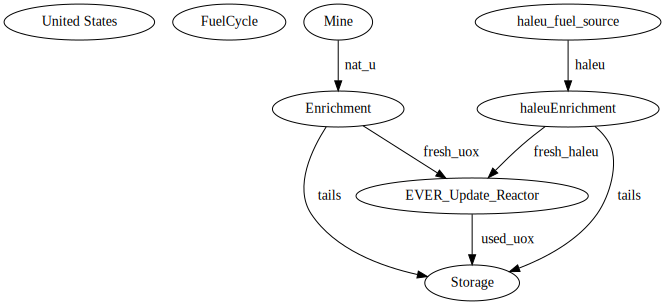

In [5]:
graphs.flow_graph(evaler, label='com')

In [6]:
reactor_list = ['EVER_Update_Reactor']
time = evaler.eval('TimeList')

Text(0, 0.5, 'Facilities [#]')

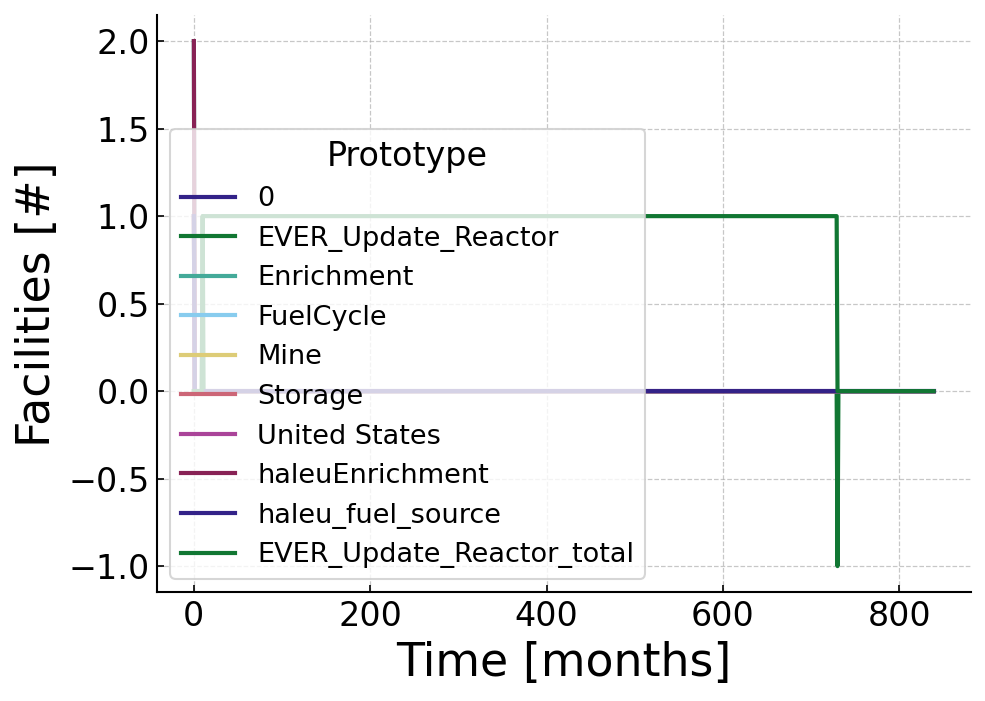

In [7]:
commission_by_prototype, commission_df = dep.comm_by_prototype(evaler, time)

decommission_by_prototype = dep.decom_by_prototype(evaler, commission_df, time)

deployment_by_prototype = dep.depl_by_prototype(commission_by_prototype, decommission_by_prototype, reactor_list)

deployment_by_prototype = dep.total_reactor(deployment_by_prototype, reactor_list)

deployment_by_prototype.plot(use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Facilities [#]')

IndexError: list index out of range

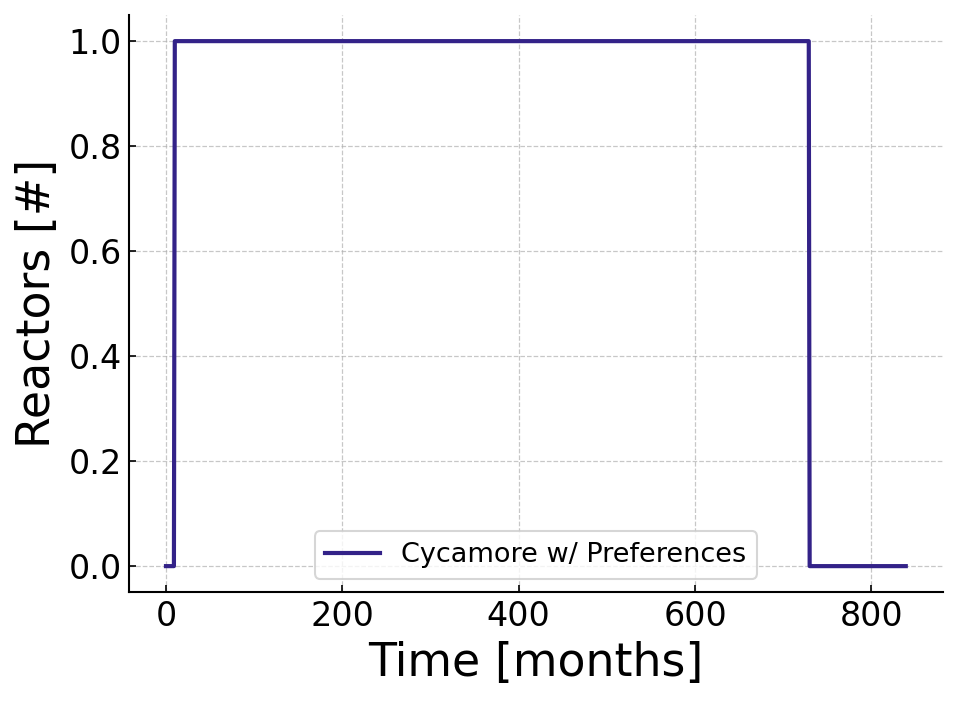

In [9]:
deployment_by_prototype[['EVER_Update_Reactor_total']].plot(use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Reactors [#]')

legend = plt.legend()
legend.get_texts()[0].set_text('Cycamore w/ Preferences')
legend.get_texts()[1].set_text('Cycamore')
legend.get_texts()[2].set_text('EVER')

In [10]:
repository_waste = timeseries.transactions(evaler=evaler, receivers=['Storage'])

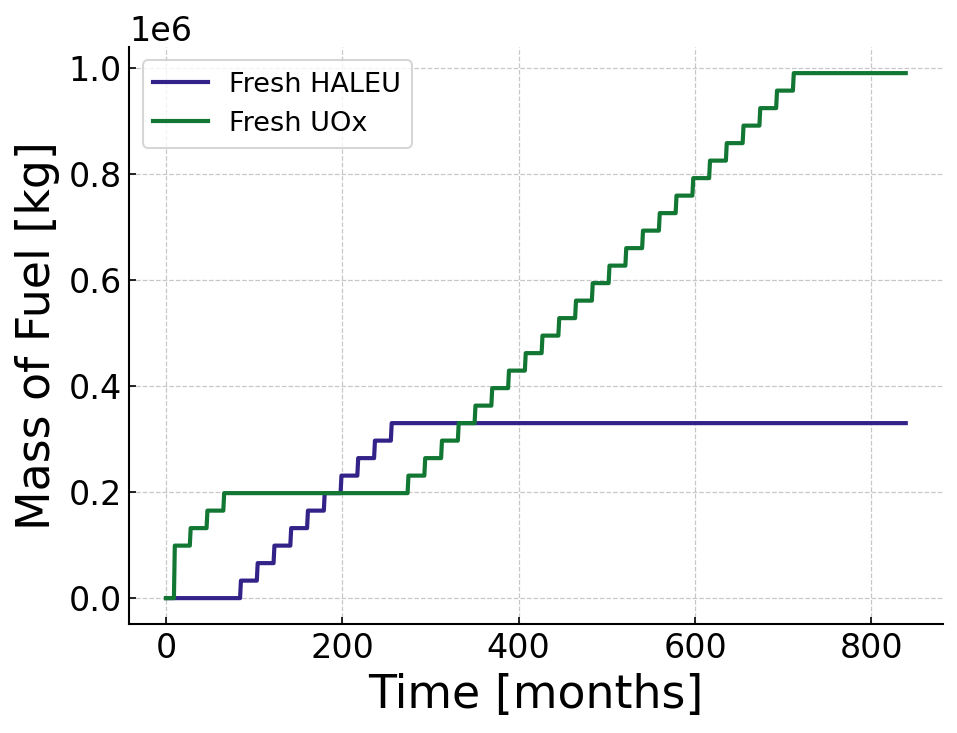

In [13]:
ever_waste_haleu = timeseries.transactions(evaler=evaler, receivers=['EVER_Update_Reactor'], commodities=['fresh_haleu'])
ever_waste_uox = timeseries.transactions(evaler=evaler, receivers=['EVER_Update_Reactor'], commodities=['fresh_uox'])

ever_waste = ever_waste_uox.copy()
ever_waste['fresh_uox'] = ever_waste['Mass']
ever_waste['fresh_haleu'] = ever_waste_haleu['Mass']

ever_waste['fresh_uox_total'] = ever_waste['fresh_uox'].cumsum()
ever_waste['fresh_haleu_total'] = ever_waste['fresh_haleu'].cumsum()

ever_waste[['Time','fresh_haleu_total','fresh_uox_total']].plot(x='Time')

plt.xlabel('Time [months]')
plt.ylabel('Mass of Fuel [kg]')
legend = plt.legend()
legend.get_texts()[0].set_text('Fresh HALEU')
legend.get_texts()[1].set_text('Fresh UOx')

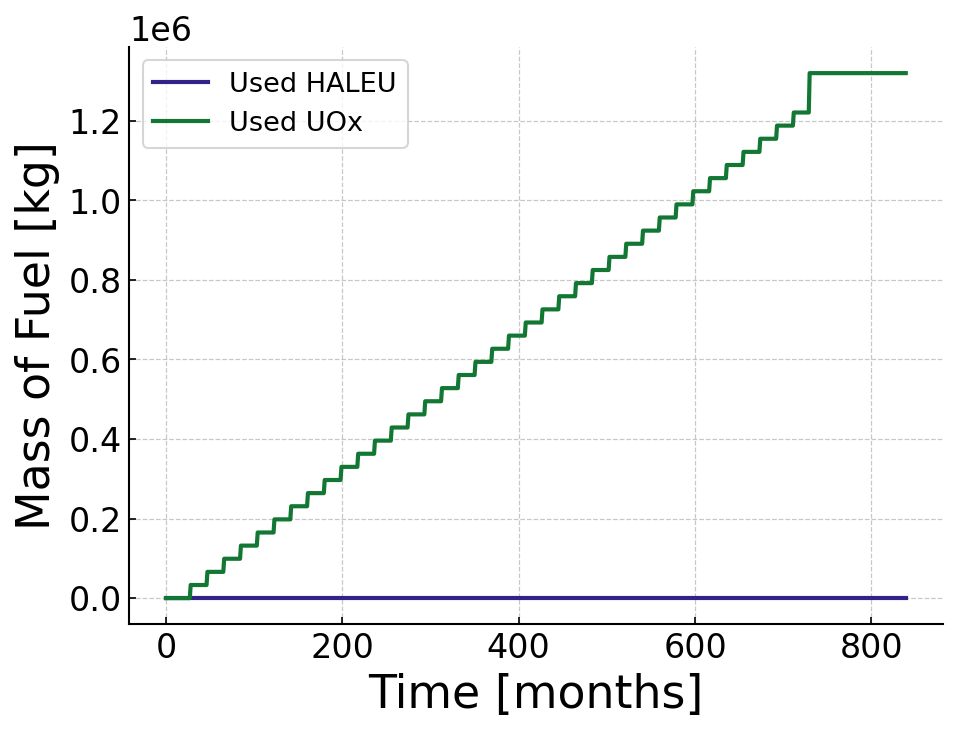

In [11]:
ever_waste_haleu = timeseries.transactions(evaler=evaler, senders=['EVER_Update_Reactor'], commodities=['used_haleu'])
ever_waste_uox = timeseries.transactions(evaler=evaler, senders=['EVER_Update_Reactor'], commodities=['used_uox'])

ever_waste = ever_waste_uox.copy()
ever_waste['used_uox'] = ever_waste['Mass']
ever_waste['used_haleu'] = ever_waste_haleu['Mass']

ever_waste['used_uox_total'] = ever_waste['used_uox'].cumsum()
ever_waste['used_haleu_total'] = ever_waste['used_haleu'].cumsum()

ever_waste[['Time','used_haleu_total','used_uox_total']].plot(x='Time')

plt.xlabel('Time [months]')
plt.ylabel('Mass of Fuel [kg]')
legend = plt.legend()
legend.get_texts()[0].set_text('Used HALEU')
legend.get_texts()[1].set_text('Used UOx')

Text(0, 0.5, 'Mass of waste [kg]')

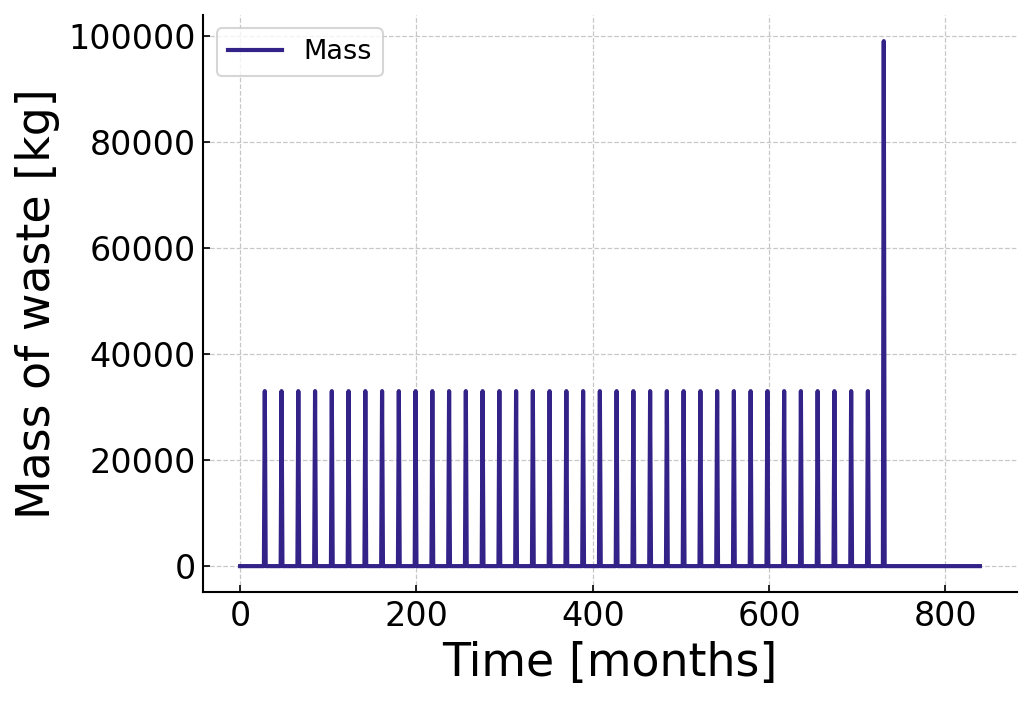

In [56]:
pref_waste = timeseries.transactions(evaler=evaler, senders=['Base_Pref_Reactor'])
pref_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

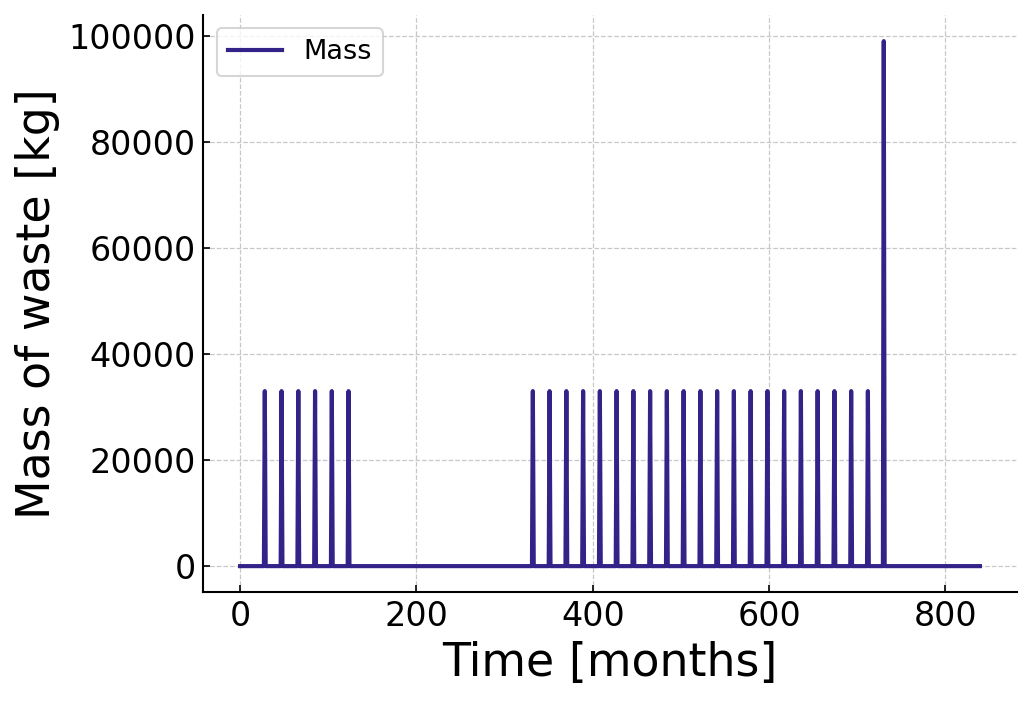

In [57]:
pref_waste = timeseries.transactions(evaler=evaler, senders=['Base_Pref_Reactor'], commodities=['used_uox'])
pref_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

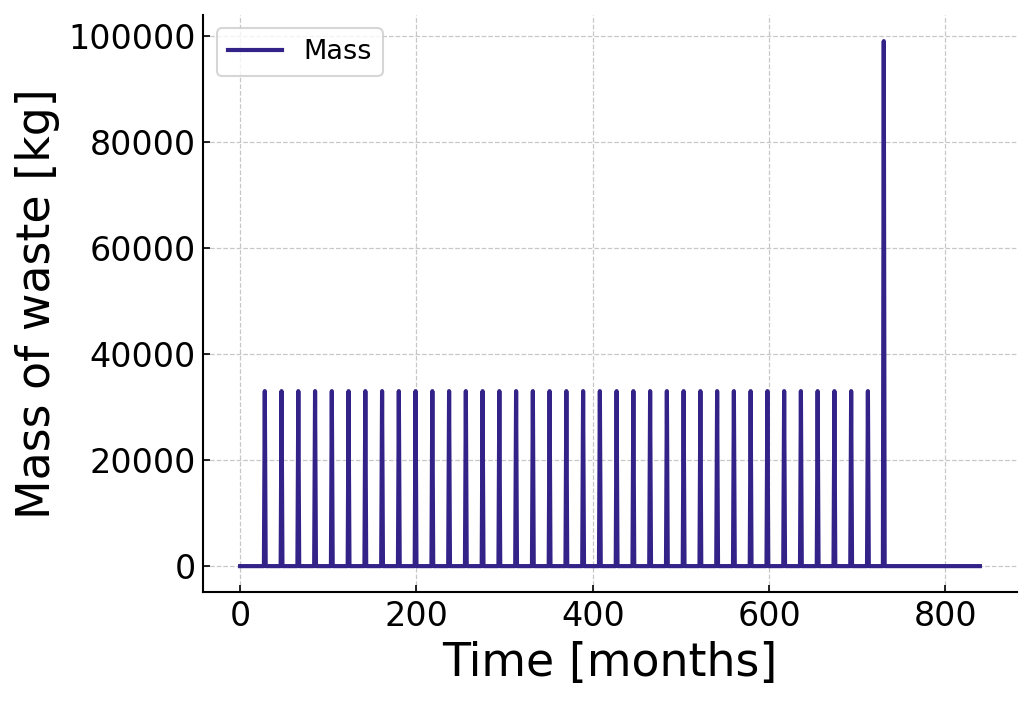

In [58]:
base_waste = timeseries.transactions(evaler=evaler, senders=['Base_Pref_Reactor'])
base_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

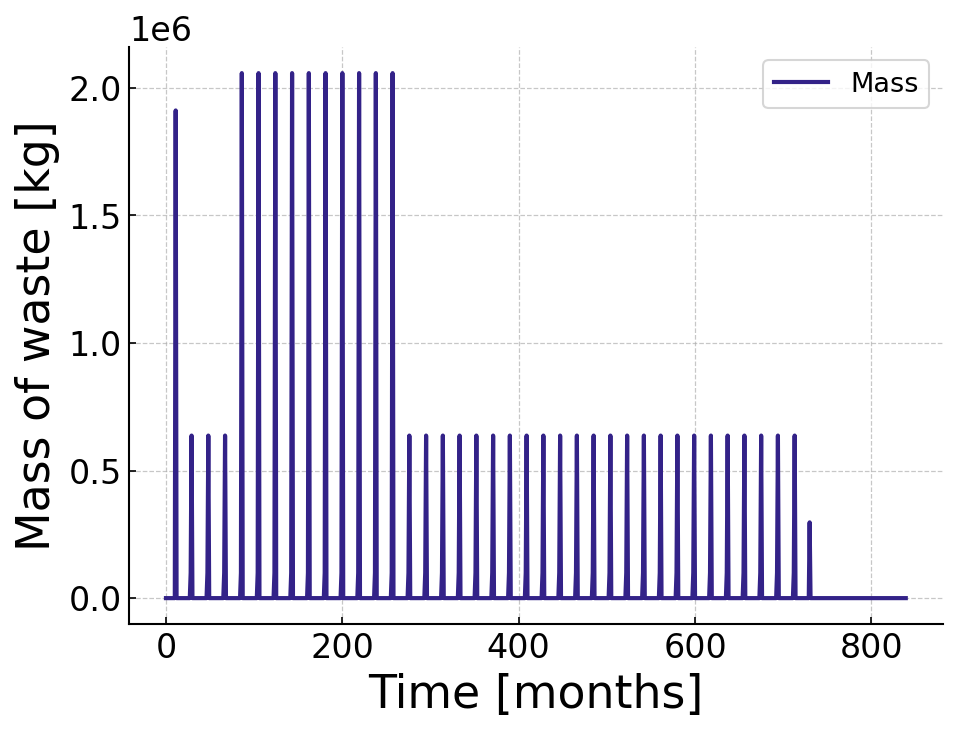

In [59]:
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

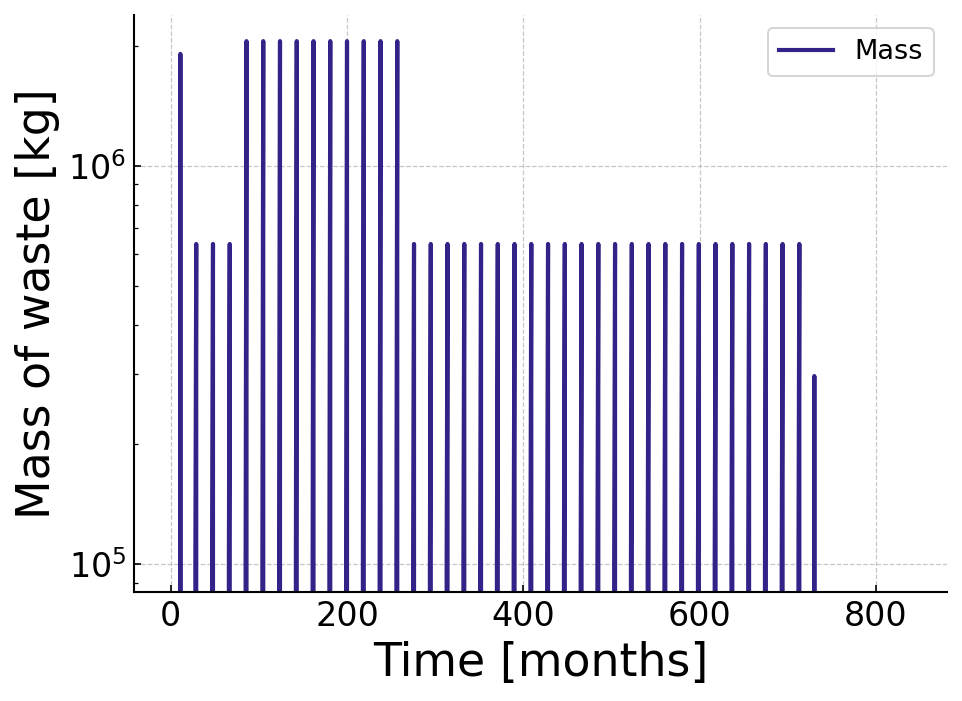

In [60]:
repository_waste.plot(x='Time', logy=True)
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

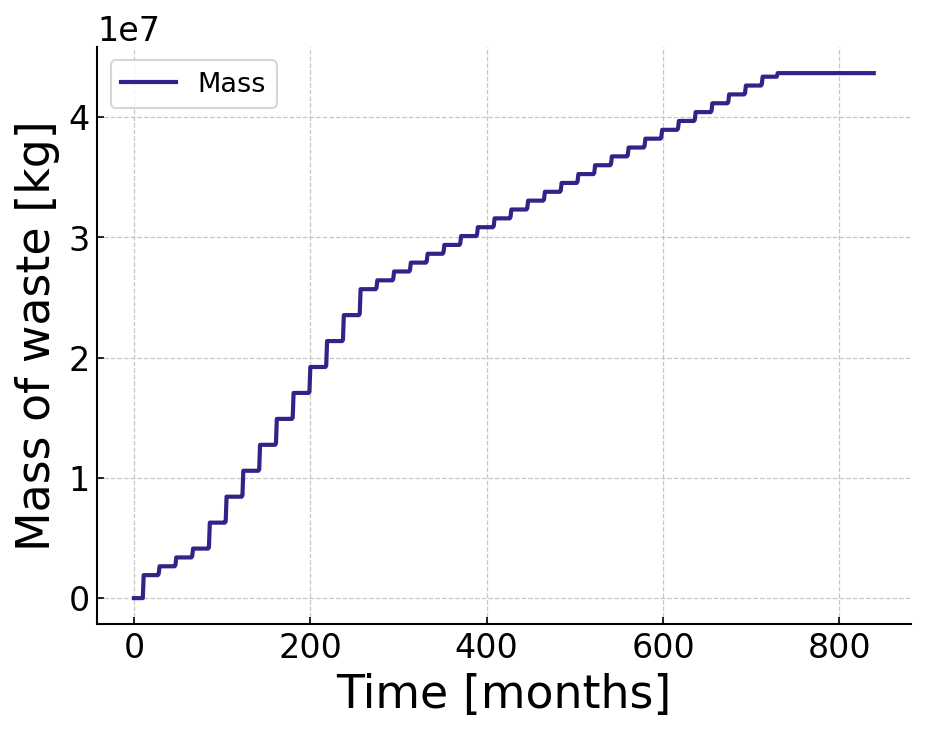

In [61]:
repository_waste['Mass'] = repository_waste['Mass'].cumsum()
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

In [62]:
reactor_input_ever = timeseries.transactions(evaler=evaler, receivers=['EVER_Update_Reactor'])

In [63]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

fuels = ['uox','haleu']

transactions = tran.used_fuel_transactions(transactions, fuels)
transactions = tran.fresh_fuel_transactions(transactions, fuels)
transactions = tran.total_used_fr_fuel(transactions, fuels)

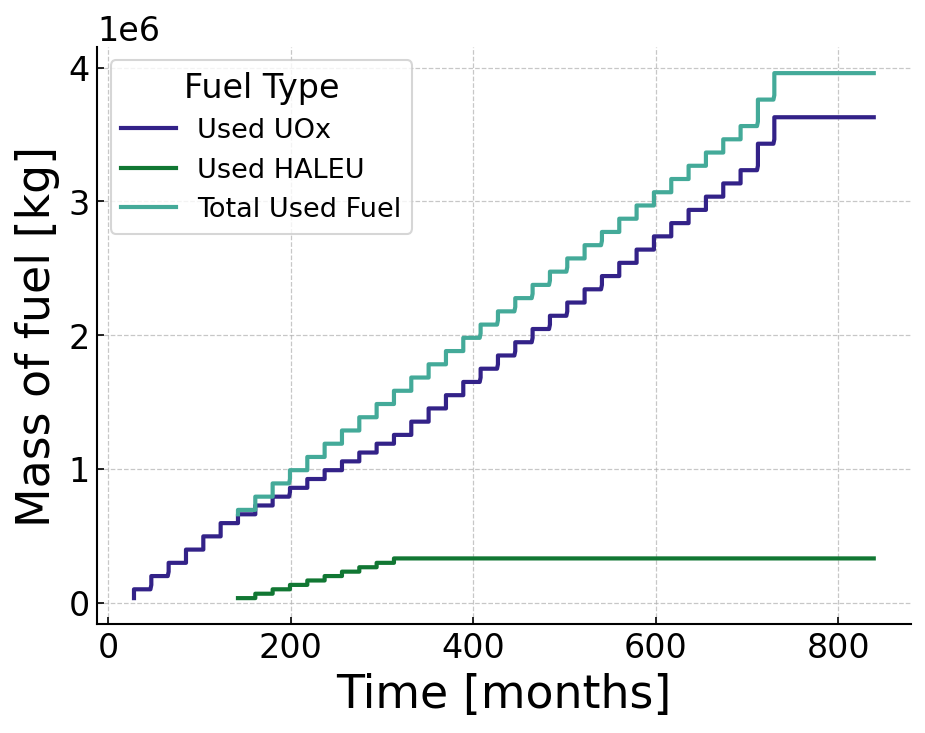

In [64]:
# Plotting cumulative fuel sent to reactors at each time step
transactions[['Time', 'used_uox_total', 'used_haleu_total', 'total_used_fuel']].plot(x = 'Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of fuel [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text('Used UOx')
legend.get_texts()[1].set_text('Used HALEU')
legend.get_texts()[2].set_text('Total Used Fuel')
legend.set_title('Fuel Type')

Text(0, 0.5, 'Mass of U235 [kg]')

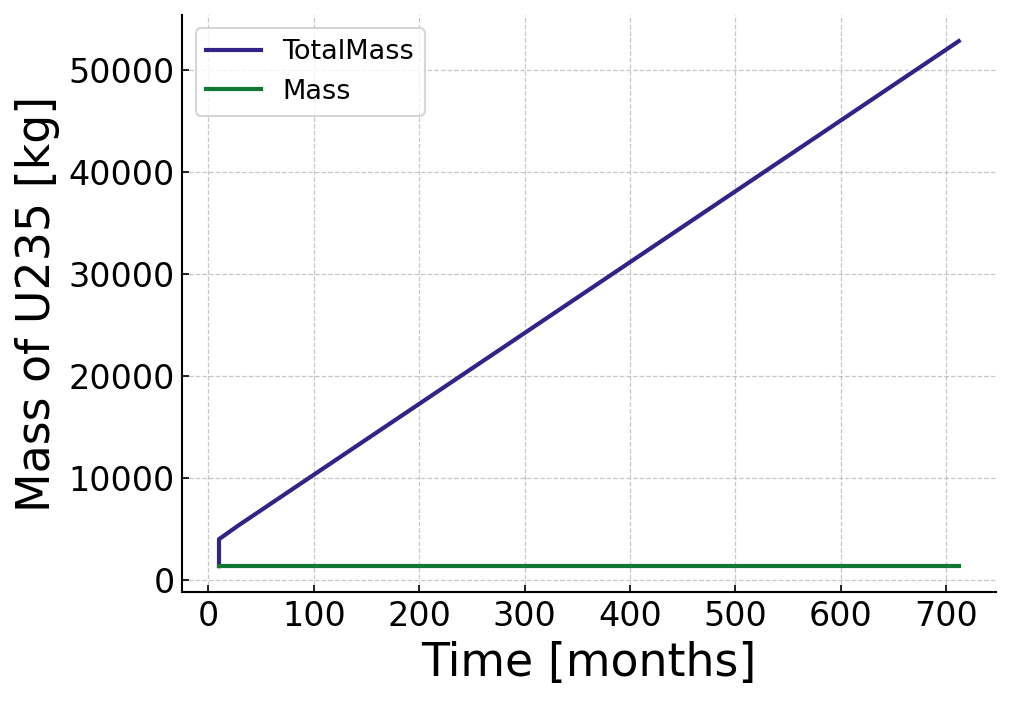

In [65]:
U235_mass = waste.transactions_nuc_built_in(evaler=evaler, receivers=['Base_Reactor'], commodities=['fresh_uox'], nucs=['92235'])

U235_mass['TotalMass'] = U235_mass['Mass'].cumsum()
U235_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of U235 [kg]')

Text(0, 0.5, 'Mass of Pu239 [kg]')

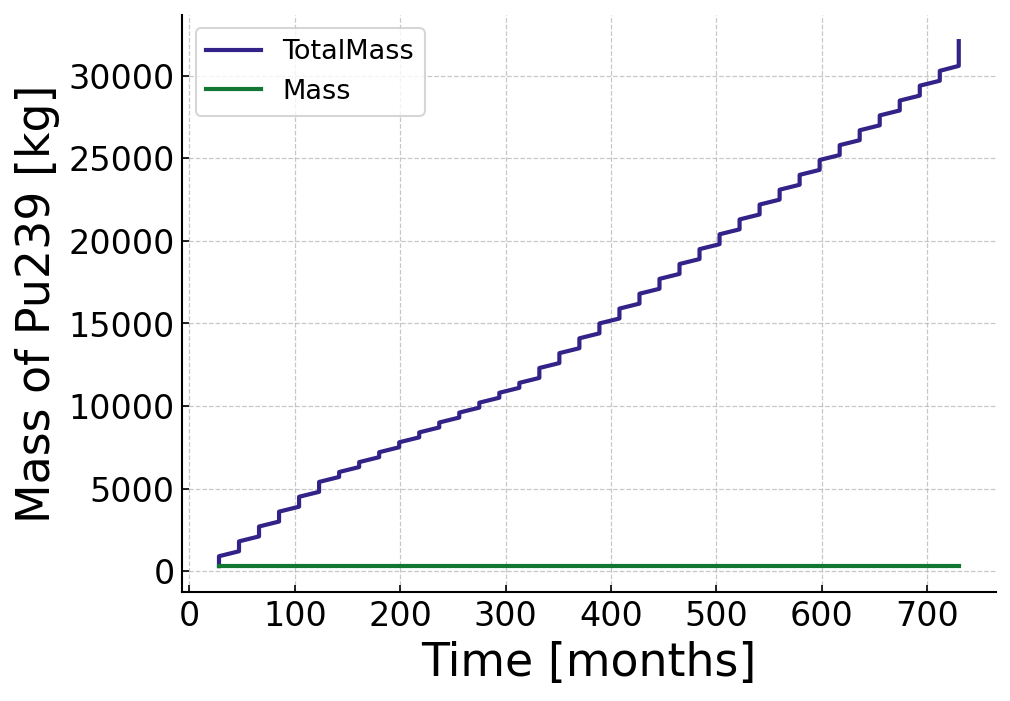

In [66]:
Pu239_mass = waste.transactions_nuc_built_in(evaler,receivers=['Storage'], commodities=['used_uox'], nucs=['94239'])

Pu239_mass['TotalMass'] = Pu239_mass['Mass'].cumsum()
Pu239_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of Pu239 [kg]')

Text(0, 0.5, 'Mass [kg]')

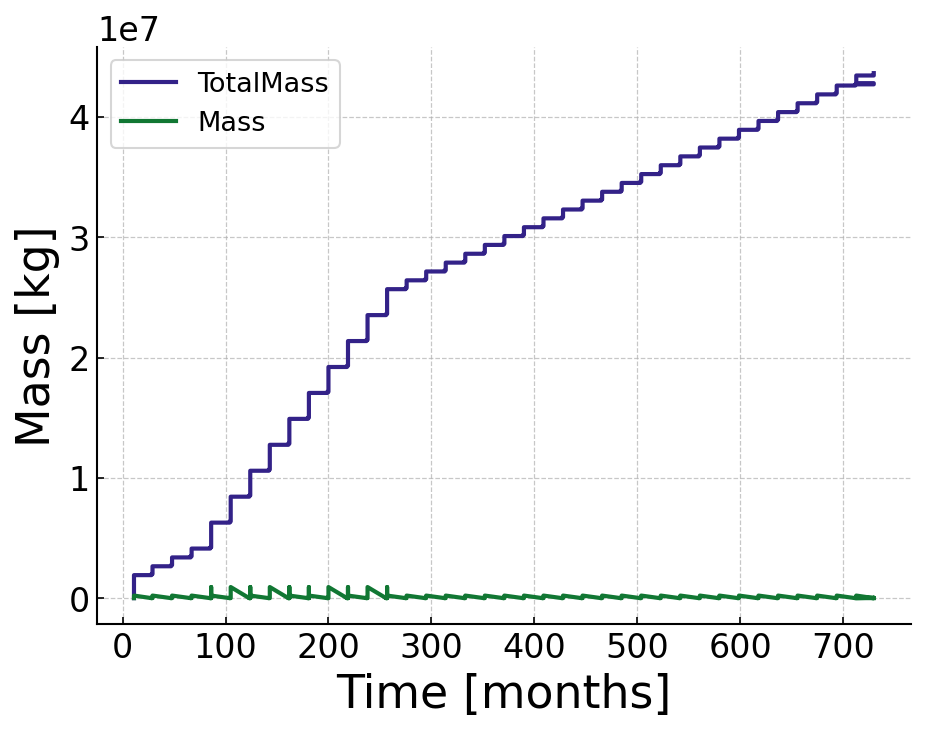

In [76]:
# waste classification isotopes
# u_isotopes = [
#     '922320000','922330000','922340000',
#     '922350000','922360000','922380000']

# np_isotopes = ['932370000']

# pu_isotopes = [
#     '942380000','942390000','942400000',
#     '942410000','942420000','942440000'] # 94236 and 94244 not included

# am_isotopes = ['952410000','952430000'] # 95242 not included

# cm_isotopes = [
#     '962440000','962430000','962460000',
#     '962450000','962480000','962470000',
#     '962350000','962370000'] # 96242 not included

all_isotopes = ['551370000','922350000','922380000','942390000']

mass_isotopes = waste.transactions_nuc_built_in(evaler,receivers=['Storage'], commodities=['used_uox','used_haleu','tails'], nucs=all_isotopes)

mass_isotopes['TotalMass'] = mass_isotopes['Mass'].cumsum()
mass_isotopes[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass [kg]')

In [77]:
times = np.arange(0,end_month)
d = {'Time':times}

# Create the dataframe and populate the columns for each isotope with zeros to
# start.
df_isotopes = pd.DataFrame(data=d)
for isotope in all_isotopes:
    df_isotopes[isotope] = 0
    df_isotopes[f'{isotope}_total'] = 0


# Track the mass of each isotope stored at each time.
for transaction in range(len(mass_isotopes)):
    for isotope in all_isotopes:
        if mass_isotopes.loc[transaction,'NucId'] == int(isotope):
            mass = mass_isotopes.loc[transaction,'Mass']
            time = mass_isotopes.loc[transaction,'Time']
            df_isotopes.loc[time,isotope] = mass

# Add up the totals for each isotope over time.
for isotope in all_isotopes:
    df_isotopes[f'{isotope}_total'] = df_isotopes[isotope].cumsum()

/tmp/ipykernel_32333/169100019.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '424.80234833659506' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_isotopes.loc[time,isotope] = mass
/tmp/ipykernel_32333/169100019.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '211976.37181996088' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_isotopes.loc[time,isotope] = mass
/tmp/ipykernel_32333/169100019.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1333.198666801333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_isotopes.loc[time,isotope] = mass
/tmp/ipykernel_32333/169100019.py:18: FutureWarning: Setting a

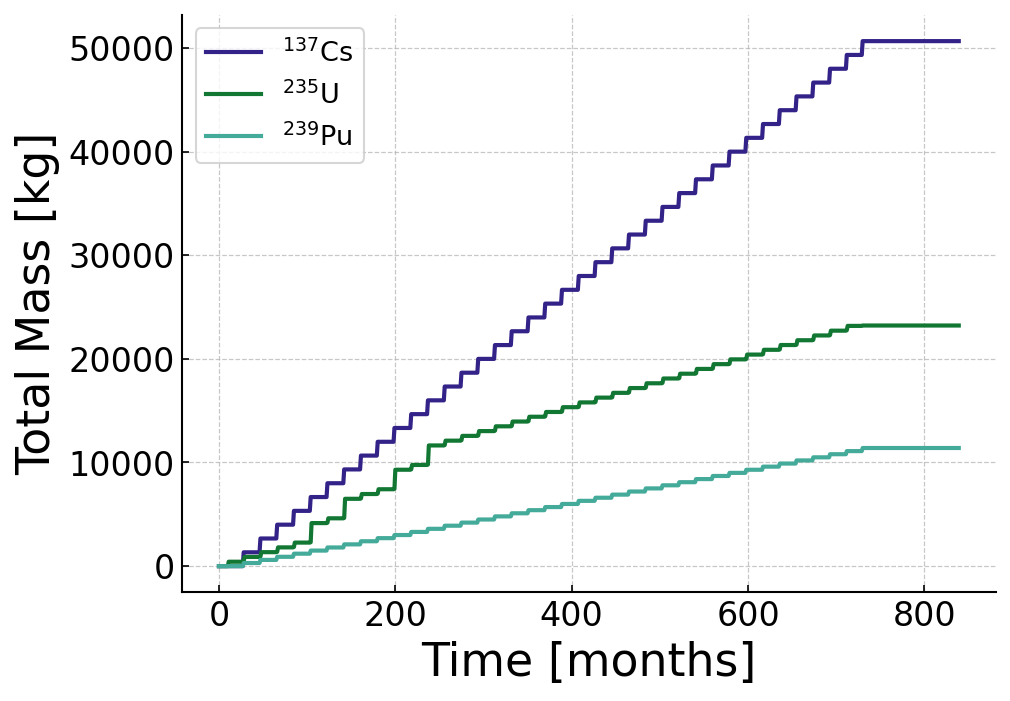

In [78]:
df_isotopes[['Time','551370000_total','922350000_total','942390000_total']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Total Mass [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text(f'$^{{137}}$Cs')
legend.get_texts()[1].set_text(f'$^{{235}}$U')
legend.get_texts()[2].set_text(f'$^{{239}}$Pu')

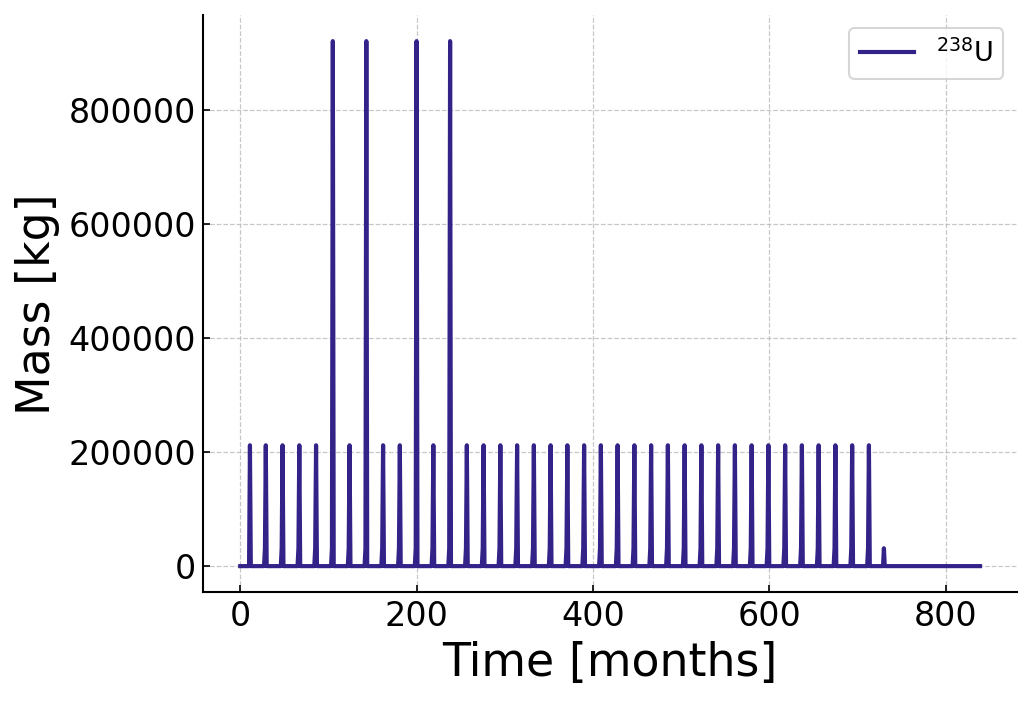

In [79]:
df_isotopes[['Time','922380000']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text(f'$^{{238}}$U')


# Sqlite Analysis
In this section, I will use basic sqlite to generate plots of the remaining data.

In [71]:
conn = sqlite3.connect('ever_update_test_out1.sqlite')

In [72]:
cursor = conn.cursor()

In [73]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
columns = cursor.fetchall()

In [74]:
cursor.execute("SELECT * FROM Transactions")
reactinfo_rows = cursor.fetchall()

for row in reactinfo_rows:
    print(row)

(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 0, 26, 28, 15, 'nat_u', 0)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 1, 27, 30, 17, 'haleu', 0)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 2, 26, 28, 32, 'nat_u', 1)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 3, 27, 30, 34, 'haleu', 1)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 4, 26, 28, 49, 'nat_u', 2)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 5, 27, 30, 51, 'haleu', 2)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 6, 26, 28, 66, 'nat_u', 3)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 7, 27, 30, 68, 'haleu', 3)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 8, 26, 28, 83, 'nat_u', 4)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 9, 27, 30, 85, 'haleu', 4)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 10, 26, 28, 100, 'nat_u', 5)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', 11, 27, 30, 102, 'haleu', 5)
(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0

In [75]:
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

for row in info_rows:
    print(row)

# define variables for the start and end of the simulation
start_year = info_rows[0][2]
start_month= info_rows[0][3]
end_month = info_rows[0][4]

(b'K\x93&\\\xe5\xdeB\x88\xad\x92\xd0k[\xaf\x96\xf3', '', 2020, 1, 840, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


In [41]:
# now we can add the rest of the dates from the simulation info
dates = pd.date_range(start=f'{start_year}-{start_month}-01', periods=end_month, freq='ME')

In [51]:
cursor.execute("SELECT * FROM DecomSchedule")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 33, 730, 730)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 34, 730, 730)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 35, 730, 730)


In [52]:
cursor.execute("SELECT * FROM BuildSchedule")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 25, 'Base_Reactor', 0, 10)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 25, 'Base_Pref_Reactor', 0, 10)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 25, 'EVER_Update_Reactor', 0, 10)


## Energy Production

In [53]:
# we will pull the decom schedule to see the ids and decomission date, to id the reactor
cursor.execute("SELECT * FROM DecomSchedule")
decom_rows = cursor.fetchall()

for row in decom_rows:
    print(row)

(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 33, 730, 730)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 34, 730, 730)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 35, 730, 730)


In [54]:
# now we will pull the supplied power to get the amount of power from each reactor at every time step
cursor.execute("SELECT * FROM TimeSeriessupplyPOWER")
supply_rows = cursor.fetchall()

#for row in supply_rows:
#    print(row)

In [55]:
# create an empty dictionary that mirrors the format of the powersupply table
energy_supply = {
    'id':[],
    'time':[],
    'energy':[]
}

# now we will pull the power at each time step for each reactor
for row in range(len(supply_rows)):
    energy_supply['id'].append(str(supply_rows[row][1]))
    energy_supply['time'].append(supply_rows[row][2])
    energy_supply['energy'].append(supply_rows[row][3])

In [56]:
# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
energy_supply_df = pd.DataFrame.from_dict(energy_supply)

In [57]:
# we will turn the ids into columns of energy and make the index time
switch_energy_supply = energy_supply_df.pivot_table(index='time', columns='id', values='energy', fill_value=0)

# now we will add a total_energy column
switch_energy_supply['total_energy'] = switch_energy_supply.iloc[:,0:].sum(axis=1)

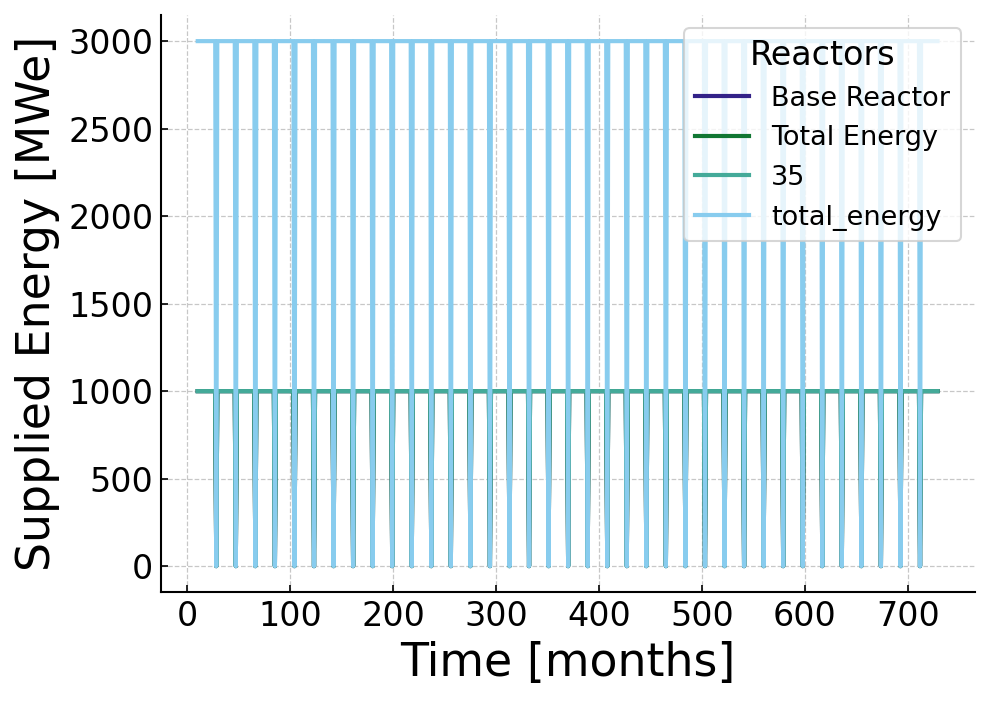

In [58]:
switch_energy_supply[['33','34','35','total_energy']].plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

In [59]:
simulation_energy_supply = pd.DataFrame(index=range(start_month,end_month), columns=switch_energy_supply.columns)
simulation_energy_supply = simulation_energy_supply.fillna(0)

for column in switch_energy_supply.columns:
    for time in range(min(switch_energy_supply.index), max(switch_energy_supply.index)):
        simulation_energy_supply.loc[time, column] = switch_energy_supply.loc[time, column]

/tmp/ipykernel_1023/2997257727.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  simulation_energy_supply = simulation_energy_supply.fillna(0)


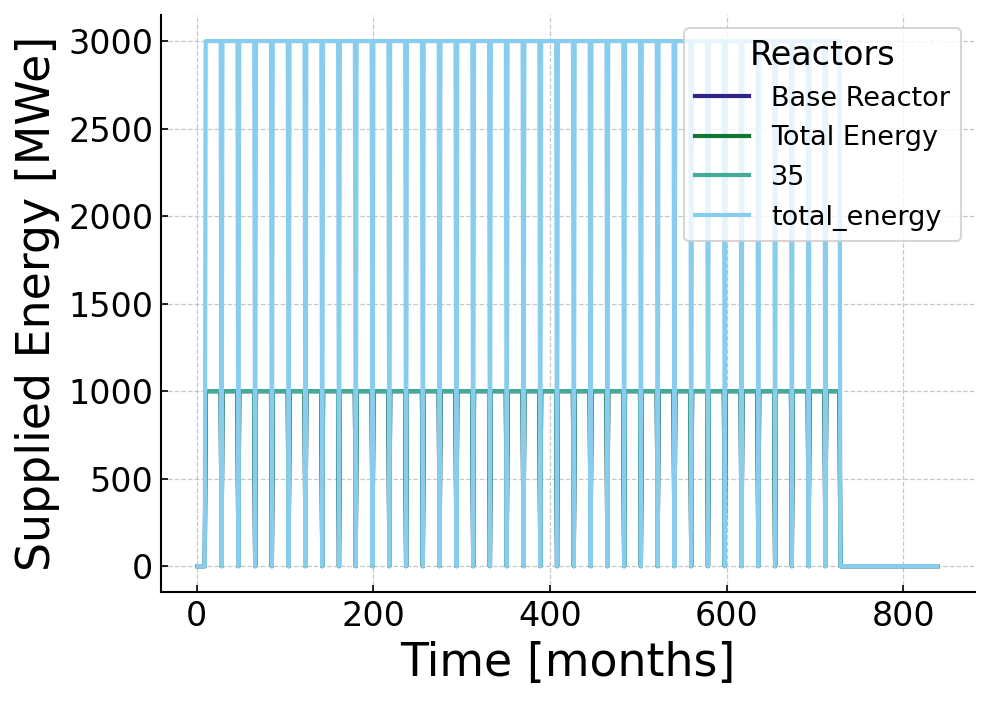

In [60]:
simulation_energy_supply.plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

## SWU

In [61]:
cursor.execute("SELECT * FROM TimeSeriesEnrichmentSWU")
swu_rows = cursor.fetchall()


for row in swu_rows:
   print(row)

(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 28, 0, 4.68543022084106e-310, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 29, 0, 0.0, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 30, 0, 0.0, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 31, 0, 0.0, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 28, 1, 4.68543022084106e-310, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 29, 1, 0.0, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 30, 1, 0.0, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 31, 1, 0.0, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 28, 2, 4.68543022084106e-310, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 29, 2, 0.0, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 30, 2, 0.0, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 31, 2, 0.0, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 28, 3, 4.68543022084106e-310, '')
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 29, 3, 0.0, '')
(b'\xc6\x7fk\xa8\x

In [62]:
# create an empty dictionary that mirrors the format of the TimeSeriesEnrichmentSWU table
swu_supply = {
    'id':[],
    'Time':[],
    'SWU':[]
}

# now we will pull the swu at each time step for each facility
for row in range(len(swu_rows)):
    swu_supply['id'].append(str(swu_rows[row][1]))
    swu_supply['Time'].append(swu_rows[row][2])
    swu_supply['SWU'].append(swu_rows[row][3])

# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
swu_supply_df = pd.DataFrame.from_dict(swu_supply)

In [63]:
# we will turn the ids into columns of energy and make the index time
switch_swu_supply = swu_supply_df.pivot_table(index='Time', columns='id', values='SWU', fill_value=0)

# now we will add a total_energy column
switch_swu_supply['total_swu'] = switch_swu_supply.iloc[:,0:].sum(axis=1)

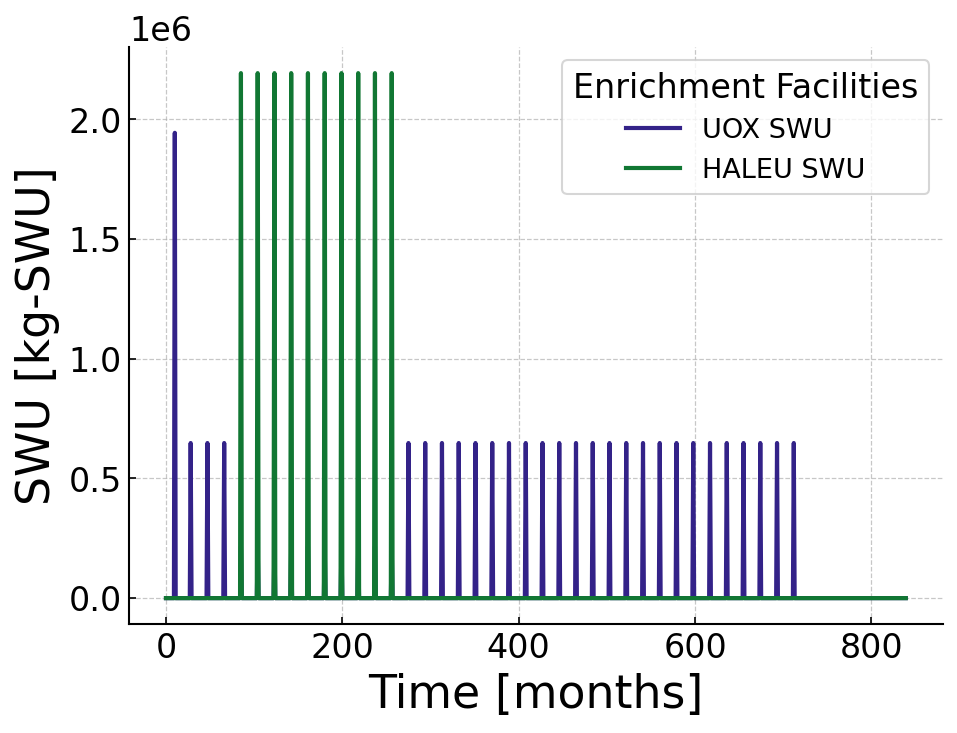

In [64]:
switch_swu_supply[['28', '30']].plot()
plt.xlabel('Time [months]')
plt.ylabel('SWU [kg-SWU]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('UOX SWU')
legend.get_texts()[1].set_text('HALEU SWU')
# legend.get_texts()[2].set_text('Total SWU')
legend.set_title('Enrichment Facilities')